<a href="https://colab.research.google.com/github/OwlusMain/RatMaze/blob/main/RatMazePublic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json, random
import numpy as np
from keras.layers import Activation, Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Reshape, BatchNormalization, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
from keras.models import save_model, load_model
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

Здесь задаётся маска лабиринта. По умолчанию параметр отвечает за проходимость клетки ($1.0$ - клетка пустая, $0.0$ - клетка заблокирована) 

In [ ]:
maze = np.array([
    [ 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
    [ 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
    [ 1., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
    [ 1., 0., 0., 0., 1., 1., 1., 0., 0., 1.],
    [ 1., 0., 0., 0., 1., 1., 1., 0., 0., 1.],
    [ 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
    [ 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
    [ 1., 1., 1., 1., 0., 0., 0., 1., 1., 1.],
    [ 1., 1., 1., 1., 0., 0., 0., 1., 1., 1.],
    [ 1., 1., 1., 1., 0., 0., 0., 1., 1., 1.]
])

Здесь расположены основные константы, которые можно изменять по своему усмотрению

In [ ]:
#CONSTANTS

#(1) Цвет объектов для отображения
colVisited = 0.8
#Обратите внимание, что параметр colRat влияет на алгоритм, так как используется для задания координаты мыши в примерах для обучения модели
colRat = 0.5
colFinish = 0.9

#(2) Основной список действий, а также их число. Может быть изменён, если требуется добавить возможность движения по другим направлениям, к примеру, по диагонали
leftAct = 0
rightAct = 1
upAct = 2
downAct = 3

actionsCnt = 4

#(3) Константа, отвечающая за вероятность того, что мышь не последует обученной модели и пойдёт в случайном направлении
randEps = 0.1

#(4) Константа, использующаяся в уравнении Беллмана для смягчения действий
impConst = 0.95

#(5) Число действий, которое запоминает мышь при передвижении, а также размер случайной выборки из них для обучения модели
ratMemSz = 100
ratTrainSamples = 50

#(6) Число "очков" за попытку совершить различные действия, а также минимально число очков, после которого итерация будет считаться провальной и начнётся заново
blockedScore = -1.5
cellScore = -0.04
visitedScore = -0.25
finishScore = 1
badEndScore = -0.5 * maze.size

#(7) Начальная позиция мыши и финиша, а также размер лабиринта. Обратите внимание, что мышь и лабиринт не должны находиться в заблокированных клетках
#Также желательно, чтобы мышь имела возможность добраться до финиша, чтобы задача вообще имела смысл
ratPos = [0, 0]
finishPos = [maze.shape[0] - 1, maze.shape[1] - 1]
mazeRows, mazeCols = maze.shape

#(8) Размер основных полносвязных слоёв. Может быть как константным, так и зависеть от, к примеру, размера лабиринта
layerSize = 25 #maze.size


#(9) Параметры числа эпох и размера батча для обучения модели на одном наборе примеров
epochsSize = 8
batchSize = 16

#(10) Параметры вывода картинки: размер сетки выводимых карт активности (их произведение должно соответствовать числу нейронов layerSize)
tensor_w = 5
tensor_h = 5

#(11) Параметр слоя, для которого формируется карта активности всех нейронов
layerForCheck = 3

#(12) Параметр нейрона, для которого формируется карта активности в формате [слой, нейрон]
curTensor = [1, 0]

Класс __Environment__. Отвечает за среду, в которой агент (мышь) будет перемещаться. Инициализируется с заданной позицией мыши и финиша, проверяет их на корректность, после чего устанавливает состояние и набор свободных клеток.

**ResetState(newRatPos)** отвечает за перезагрузку состояния среды. Выставляет мышь в первоначальное положение, сбрасывает массив посещённых клеток, устанавливает текущее количество очков в 0

**GetValidActions(cell)** возвращает массив доступных мыши действий в заданной клетке

**MakeAction(action)** производит действие, если оно доступно и возвращает информацию о том, было ли действие совершено

**CountScore()** на основе произведённого действия считает число полученных очков

**BuildEnvState()** строит на основании текущего положения мыши и строения лабиринта одномерный массив envState, формата входа нейронной сети

**Act(action)** выполняет действие, считает число полученных очков и новое состояние envState, после чего возвращает эти результаты

**CheckStatus()** проверяет условие завершения движения

In [ ]:
class Environment(object):
    rat = [0, 0]
    def __init__(self, rat=ratPos.copy()):
        self.finish = finishPos
        self.freeCells = []
        for i in range(mazeRows):
          for j in range(mazeCols):
            if maze[i][j] == 1.0 and (i, j) != finishPos:
              self.freeCells.append([i, j])
        if maze[self.finish[0]][self.finish[1]] == 0.0:
            raise Exception("Blocked finish!")
        if not self.rat in self.freeCells:
            raise Exception("Blocked rat!")
        self.ResetState(self.rat)

    def ResetState(self, newRatPos):
        self.rat = newRatPos
        self.curState = 'start'
        self.totalScore = 0.0
        self.visitedCell = set()

    def GetValidActions(self, cell=None):
        if cell != None:
            self.rat = cell
        actions = list(range(actionsCnt))
        if self.rat[0] == 0 or maze[self.rat[0] - 1][self.rat[1]] == 0.0:
            actions.remove(upAct)
        if self.rat[0] == mazeRows - 1 or maze[self.rat[0] + 1][self.rat[1]] == 0.0:
            actions.remove(downAct)
        if self.rat[1] == 0 or maze[self.rat[0]][self.rat[1] - 1] == 0.0:
            actions.remove(leftAct)
        if self.rat[1] == mazeCols - 1 or maze[self.rat[0]][self.rat[1] + 1] == 0.0:
            actions.remove(rightAct)

        return actions

    def MakeAction(self, action):
        if maze[self.rat[0]][self.rat[1]] == 1.0:
            self.visitedCell.add(tuple(self.rat))

        validActions = self.GetValidActions()

        if action in validActions:
            self.curState = 'valid'
            if action == leftAct:
                 self.rat[1] -= 1
            elif action == rightAct:
                 self.rat[1] += 1
            if action == upAct:
                self.rat[0] -= 1
            elif action == downAct:
                self.rat[0] += 1
        else:
           self.curState = 'invalid'

    def CountScore(self):
        if self.rat == finishPos:
            return finishScore
        if tuple(self.rat) in self.visitedCell:
            return visitedScore
        if self.curState == 'invalid':
            return blockedScore
        if self.curState == 'valid':
            return cellScore

    def BuildEnvState(self):
        mazeState = maze.copy()
        mazeState[self.rat[0]][self.rat[1]] = colRat
        envState = mazeState.reshape((1, -1))
        return envState

    def Act(self, action):
        self.MakeAction(action)
        score = self.CountScore()
        self.totalScore += score
        status = self.CheckStatus()
        envState = self.BuildEnvState()
        return envState, score, status

    def CheckStatus(self):
        if self.totalScore < badEndScore:
            return 'lose'
        if self.rat == self.finish:
            return 'win'

        return 'continue'

**Show(curEnv)** отображает текущее состояние движения типа Environment в графическом виде (отображает текущий лабиринт, мышь, финиш и пройденный мышью путь)

In [ ]:
def Show(curEnv):
    plt.grid('on')
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, mazeRows, 1))
    ax.set_yticks(np.arange(0.5, mazeCols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(maze)
    for curCell in curEnv.visitedCell:
        canvas[curCell[0]][curCell[1]] = colVisited
    canvas[curEnv.rat[0]][curEnv.rat[1]] = colRat
    canvas[finishPos[0]][finishPos[1]] = colFinish
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

**FindPath(model, curEnv, newRatCell, isGenData)** моделирует и выводит путь мыши для текущей модели начиная с newRatCell. (isGenData = True) - функция выводит информацию об активности нейронов и положении мыши на каждой итерации

In [ ]:
def FindPath(model, curEnv, newRatCell, isGenData = False):
    inp = model.input                              
    outputs = [layer.output for layer in model.layers]       
    functor = K.function([inp, K.learning_phase()], outputs )
    tensorOuts = np.zeros([0, layerSize])
    ratPosOuts = []

    curEnv.ResetState(newRatCell)
    envState = curEnv.BuildEnvState()
    while True:
        actArr = model.predict(envState)
        if(isGenData) :
            tensorOuts = np.append(tensorOuts, np.reshape(functor([envState, 1])[layerForCheck][0][:], (1, layerSize)), axis=0)
            ratPosOuts.append(curEnv.rat.copy())

        action = np.argmax(actArr[0])

        newEnvState, reward, game_status = curEnv.Act(action)
        envState = newEnvState
        if game_status == 'win':
            return True, tensorOuts, ratPosOuts
        elif game_status == 'lose':
            return False, tensorOuts, ratPosOuts

**TrainCompleteCheck(model, curEnv)** проверяет условие завершения процесса обучения (в текущем случае мы обучаем до того момента, пока модель не научится находить путь из исходной клетки в финишную, возможно учить, к примеру, находить путь от всех клеток, однако это слишком долгий процесс)

In [ ]:
def TrainCompleteCheck(model, curEnv):
    if not curEnv.GetValidActions(ratPos.copy()):
        return False
    if not FindPath(model, curEnv, ratPos.copy())[0]:
        return False
    return True

Класс **Experience**. отвечает за запоминание последних действий мыши, а также формирование и выдачу выборки для обучения в нужном формате. Инициализируется заданной моделью, а также пустым списком памяти

**RememberEpisode(episode)** вносит в память объект episode, содержащий информацию о предыдущем состоянии, совершённом действии, новом состоянии, условии конца, и количестве очков за совершённое действие

**Predict(envState)** возвращает результат работы модели на состоянии envState

**GetSamplesFromMemory()** возвращает сгенерированную тренировочную выборку. Именно здесь используется уравнение Беллмана для оптимизации действия, совершённого мышью (мы считаем это действие хорошим)

In [ ]:
class Experience(object):
    def __init__(self, model):
        self.model = model
        self.ratMemory = []

    def RememberEpisode(self, episode):
        self.ratMemory.append(episode)
        if len(self.ratMemory) > ratMemSz:
            del self.ratMemory[0]

    def Predict(self, envState):
        return self.model.predict(envState)[0]

    def GetSamplesFromMemory(self):
        dataSz = min(len(self.ratMemory), ratTrainSamples)
        inputs = np.zeros((dataSz, mazeRows * mazeCols))
        targets = np.zeros((dataSz, actionsCnt))

        for i, j in enumerate(np.random.choice(len(self.ratMemory), dataSz, replace=False)):
            envState, action, score, newEnvState, isOver = self.ratMemory[j]
            inputs[i] = self.ratMemory[j][0]
            targets[i] = self.Predict(self.ratMemory[j][0])
            scoreBetter = np.max(self.Predict(self.ratMemory[j][3]))
            if isOver:
                targets[i, self.ratMemory[j][1]] = self.ratMemory[j][2]
            else:
                targets[i, self.ratMemory[j][1]] = self.ratMemory[j][2] + impConst * scoreBetter  #Уравнение Беллмана
        return inputs, targets

**ModelTrain(model)** выполняет процесс движения мыши по лабиринту и обучения модели в ходе этого движения, а также проверяет на выполнение условия решения задачи. Основная функция для всей задачи

In [ ]:
def ModelTrain(model):
    environment = Environment()

    curExp = Experience(model)

    cntEpochs = 0

    while (True):
        loss = 0.0
        newRatCell = random.choice(environment.freeCells)
        environment.ResetState(newRatCell)
        isOver = False

        envState = environment.BuildEnvState()

        cntEp = 0
        while not isOver:
            validActions = environment.GetValidActions()
            if not validActions: break

            if np.random.rand() < randEps:
                action = random.choice(validActions)
            else:
                action = np.argmax(curExp.Predict(envState))

            newEnvState, score, status = environment.Act(action)
            if status == 'lose':
                isOver = True
            else :
                if status == 'win':
                    isOver = True
                episode = [envState, action, score, newEnvState, isOver]
                curExp.RememberEpisode(episode)
                cntEp += 1

            inputs, targets = curExp.GetSamplesFromMemory()
            model.fit(inputs, targets, epochs=epochsSize,batch_size=batchSize, verbose=0)
            loss = model.evaluate(inputs, targets, verbose=0)
            envState = newEnvState
    
        print("Current epoch: %d, current loss: %4f, episodes count: %d" % (cntEpochs, loss, cntEp))
        if TrainCompleteCheck(model, environment):
            print("Finished training!")
            break
        cntEpochs += 1

    save_model(model, "ratModel.hdf5")

**BuildModel(maze)** строит модель по лабиринту maze. Можно заменять какой угодно моделью, но главное, чтобы она удовлетворяла формату входа и выхода

Формат входа: одномерный массив размера числа клеток в лабиринте, где разными числами помечены свободные клетки, заблокированные клетки и клетка с мышью

Формат выхода: массив размера числа действий

In [ ]:
def BuildModel(maze):
    model = Sequential()
    model.add(Dense(layerSize, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(layerSize))
    model.add(PReLU())
    model.add(Dense(actionsCnt))
    model.compile(optimizer='adam', loss='mse')

    return model

Здесь можно проверить Environment на успешное построение и отображение лабиринта

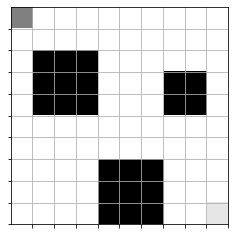

In [ ]:
curEnv = Environment()
Show(curEnv)

Здесь запускается процесс обучения модели. Модель автоматически сохраняется в файл **ratModel.hdf5** после решения задачи

In [ ]:
model = BuildModel(maze)
ModelTrain(model)

Current epoch: 0, current loss: 0.002509, episodes count: 231
Current epoch: 1, current loss: 0.120600, episodes count: 210
Current epoch: 2, current loss: 0.086647, episodes count: 17
Current epoch: 3, current loss: 0.022666, episodes count: 65
Current epoch: 4, current loss: 0.027888, episodes count: 26
Current epoch: 5, current loss: 0.010317, episodes count: 6
Current epoch: 6, current loss: 0.053974, episodes count: 212
Finished training!


При необходимости загружаем свою модель с названием **ratModel.hdf5** (в формате .hdf5)

In [ ]:
model = load_model("ratModel.hdf5")

**normalize_data(tensor_values, maze, isForShow)** нормализует данные по тензорам (минимальное 0, максимальное 1, остальные в промежутке. Данные по заблокированным клеткам и финишу убираются за неимением смысла). isForShow отвечает за преобразование в формат вывода результатов как изображения (в таком случае все значащие величины становятся на отрезке $[0.5, 1]$, а заблокированные и финиш получают значение $0$)

In [ ]:
def normalize_data(tensor_values, maze, isForShow = False) :
    maze2 = 1 - maze
    maze[finishPos[0]][finishPos[1]] = 1
    tensor_values *= maze2
    tensor_values += maze * maze.size * 100
    min_val = tensor_values.min()
    tensor_values *= maze2
    tensor_values -= maze * maze.size * 100
    max_val = tensor_values.max()
    tensor_values *= maze2
    tensor_values -= min_val
    tensor_values *= maze2
    tensor_values /= max_val - min_val
    if isForShow :
        tensor_values *= 0.5
        tensor_values += 0.5
        tensor_values *= maze2

**show_grid(tensor_values)** выводит данные в виде изображения

In [ ]:
def show_grid(tensor_values) :
    plt.grid('on')
    nrows, ncols =  tensor_values.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    img = plt.imshow(tensor_values, cmap='hot')
    return img

**check_tensor(model, curEnv, tensor_pos, isForShow)** формирует карту активности на всём лабиринте для заданного нейрона в формате [слой, нейрон]. isForShow регулирует то же, что и в normalize_data выше

In [ ]:
def check_tensor(model, curEnv, tensor_pos, isForShow = False):
    inp = model.input                              
    outputs = [layer.output for layer in model.layers]       
    functor = K.function([inp, K.learning_phase()], outputs )

    tensor_values = np.zeros(maze.shape)

    for i in range(maze.shape[0]) :
        for j in range(maze.shape[1]) :
            if(maze[i][j] == 0) :
                continue
            curEnv.ResetState((i, j))
            envstate = curEnv.BuildEnvState()
            model.predict(envstate)
            tensor_out = functor([envstate, 1])[tensor_pos[0]][0][tensor_pos[1]]
            tensor_values[i][j] = tensor_out

    normalize_data(tensor_values, 1 - maze.copy(), isForShow)
    show_grid(tensor_values)

Выводим карту активности для нужного нейрона curTensor

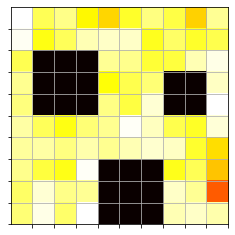

In [ ]:
lMaze = Environment()
check_tensor(model, lMaze, curTensor, True)

Формируем и сохраняем изображение, содержащее карты активности всех тензоров слоя **layerForCheck**

In [ ]:
plt.figure(figsize=(tensor_w, tensor_h))
for i in range(tensor_w * tensor_h) :
        plt.subplot(tensor_w, tensor_h, i + 1)
        check_tensor(model, lMaze, [layerForCheck, i], True)
plt.tight_layout()
plt.savefig('tensorsMap.png')
plt.close()   


Проверяем и выводим путь от исходной позиции до финишной, сгенерированный моделью

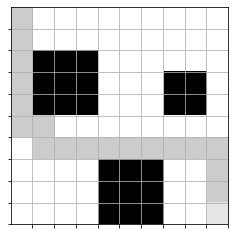

In [ ]:
lMaze = Environment()
FindPath(model, lMaze, ratPos.copy())
Show(lMaze)

**NormalizeDataPath(tensorPath)** отвечает за то же самое, что и normalize_data, только для результатов нейрона на пути

In [ ]:
def NormalizeDataPath(tensorPath) :
    minVal = tensorPath.min()
    maxVal = tensorPath.max()
    tensorPath -= minVal
    tensorPath /= maxVal - minVal
    return tensorPath

Формируем и выводим данные об активности всех нейронов слоя layerForCheck для исходного пути в файл **data.csv** формата .csv

In [ ]:
resFlag, tensorOuts, ratOuts = FindPath(model, lMaze, ratPos.copy(), True)
curFile = open("data.csv", "w")

curFile.write("Step, x, y")
for i in range(tensorOuts.shape[1]):
    tensorOuts[:, i] = NormalizeDataPath(tensorOuts[:, i])
    curFile.write(",Neuron " + str(i + 1))
curFile.write("\n")

for i in range(tensorOuts.shape[0]):
    curFile.write(str(i + 1) + "," + str(ratOuts[i][0]) + "," + str(ratOuts[i][1]))
    for j in range(tensorOuts.shape[1]):
        curFile.write("," + str(tensorOuts[i][j]))
    curFile.write("\n")